# Implementation of Wu et al Spatio-Temporal Back Propagation.
### Implementation with Nest neurons `iaf_psc_delta`

See the math in README.ipynb

In [1]:
import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import numpy as np
import matplotlib.pyplot as plt
import data_loader
from model import LIF_network
from solver import Solver
import time
import pickle
import nest

%load_ext autoreload
%autoreload 2

In [2]:
num_classes = 10
(x_train, y_train),(x_test, y_test) = data_loader.load(path='../dataset')
one_hot_train, one_hot_test = data_loader.one_hot_encode(y_train, y_test, num_classes)

In [129]:
nest.ResetKernel()
model = LIF_network(hidden_size=10, T=30.)

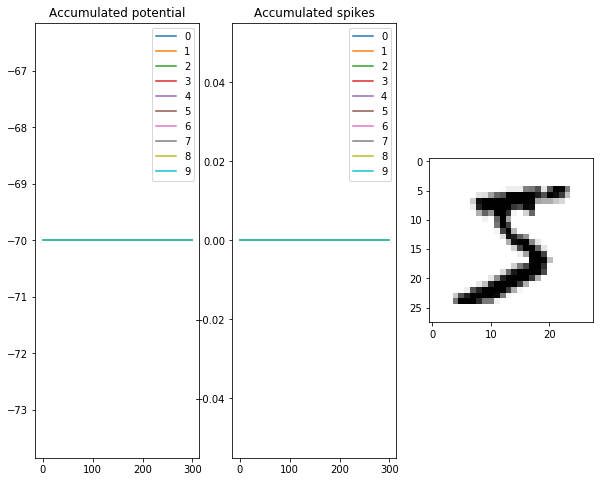

In [130]:
n_samp = 1
samples = x_train[:n_samp]
nest.ResetNetwork()
model.run(samples)
model.store()
#cumU = np.cumsum(model.hidden.potential, axis=1)
#cumO = np.cumsum(model.hidden.spikes, axis=1)
cumU = model.hidden.potential
cumO = model.hidden.spikes
idx = np.arange(10)
for i in range(n_samp):
    U = cumU[i, :, :10]
    O = cumO[i, :, :10]
    #print("True label is", y_train[i])
    plt.figure(i, figsize=(10,8))
    plt.subplot(131)
    plt.plot(U)
    plt.legend(idx)
    plt.title("Accumulated potential")
    plt.subplot(132)
    plt.plot(O)
    plt.legend(idx)
    plt.title("Accumulated spikes")
    plt.subplot(133)
    plt.imshow(np.reshape(samples[i], (28,28)), cmap=plt.cm.binary)


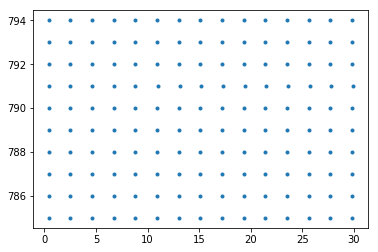

In [131]:
dSD = nest.GetStatus(model.hidden.detector)[0]
events = dSD["events"]["senders"]
ts = dSD["events"]["times"]
#Vm2 = dmm["events"]["V_m"][1::num_class]
#t2 = dmm["events"]["times"][1::num_class]

plt.figure(1)
#pylab.plot(t1, np.cumsum(Vm1))
plt.plot(ts, events, '.')

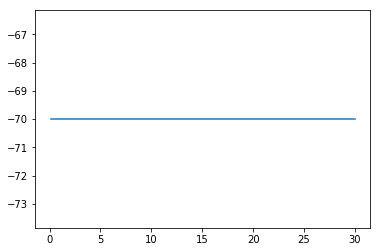

In [132]:
dmm = nest.GetStatus(model.hidden.multimeter)[0]
events = dmm["events"]["senders"] == 786
Vm = dmm["events"]["V_m"][events]
tm = dmm["events"]["times"][events]
#Vm2 = dmm["events"]["V_m"][1::num_class]
#t2 = dmm["events"]["times"][1::num_class]

plt.figure(1)
#pylab.plot(t1, np.cumsum(Vm1))
plt.plot(tm, Vm)

In [86]:
solver = Solver(n_epochs=3, batch_size=20)

In [87]:
start = time.time()
n_train = 30
n_test = 10
solver.train(model, x_train[:n_train], one_hot_train[:n_train], x_test[:n_test], one_hot_test[:n_test])
stop = time.time()
print((stop-start)/60)

epoch 1 has ended
Loss: 0.3328637552634592
Train Acc.: 0.05 Test Acc.: 0.1
epoch 2 has ended
epoch 3 has ended
Loss: 0.33213267878563896
Train Acc.: 0.05 Test Acc.: 0.1
0.5982471267382304


In [15]:
dmm = nest.GetStatus(model.hidden.multimeter)[0]

In [126]:
cumU.shape

(3, 100, 10)

In [127]:
np.unique(dmm["events"]["times"]).shape


(302,)

In [62]:
nest.GetKernelStatus("min_delay")

0.1

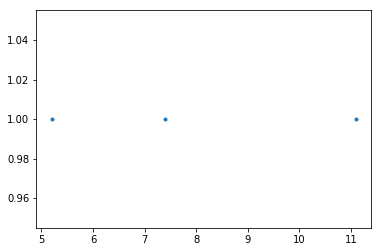

In [51]:
dSD = nest.GetStatus(net.hidden.detector)[0]
mask_1 = dSD["events"]["senders"] == 3
ts = dSD["events"]["times"]#[::num_class]
#Vm2 = dmm["events"]["V_m"][1::num_class]
#t2 = dmm["events"]["times"][1::num_class]

pylab.figure(1)
#pylab.plot(t1, np.cumsum(Vm1))
pylab.plot(ts, mask_1, '.')

In [11]:
a = np.array([[1, 2], [3,4]])
s = [{"x": a[i,j]} for j in range(2) for i in range(2)]

In [28]:
model.hidden.W

array([[-4.90671806,  1.30882504,  3.28160902, ...,  4.43150232,
        -2.17100973,  2.64211879],
       [ 2.35769597,  1.63033263,  4.48038785, ...,  4.218954  ,
         4.72766268, -1.65827643],
       [ 2.79725081, -1.17636862, -2.40341804, ...,  0.22246853,
         0.65901157, -3.38707713],
       ...,
       [ 2.11021371, -2.87112791, -2.94893397, ..., -2.28661298,
        -4.65939251,  0.9383759 ],
       [ 0.41041125, -0.97506412,  0.09484044, ...,  2.92629972,
        -1.89531049,  1.08912677],
       [-3.53705819,  0.434167  , -3.01034593, ...,  0.94150698,
         0.97217295,  3.2179692 ]])

In [156]:
def initW(size_in, size_out):
    # initialization function for network weights. Recommended form of Wu et al.
    W = 2*np.random.random((size_out, size_in)) - 1
    sqrW = W**2
    normW = np.sqrt(np.sum(sqrW, axis=1)).reshape((size_out, 1))
    return W / normW

In [495]:
nest.ResetKernel()
params = {
    #"E_L": -80., # U_rest ie relaxed potential when I_e=0 (mV)
    "t_ref": .1, # refactory time (no spikes during this time) (ms)
    #"V_m": 0., # initial membrane potential (mV)
    #"V_min": -.5, # minimal potential that the membrane can reach (mV)
    #"V_reset": -70., # potential just after firing (mV)
    "V_th": -55., # threshold potential (mV)
    #"C_m": 1., # capacity of the membrane (pF)
    "tau_m": 5.,# neuron exp time constant (ms)
    "tau_Ca": 100.
    #"I_e": 5. # input current (pA)
}

n_in = 10
n_out = 1
inpt = nest.Create("spike_generator", n_in)
#np.random.seed(1)
rand = np.random.random(n_in)
#nest.SetStatus(inpt, [{"start": 0., "stop": 100., "rate": rand[i]*999} for i in range(n_in)])
nest.SetStatus(inpt, [{"origin": .1, 
                        "start": .1, 
                       "stop":10.1, 
                       "spike_times": np.linspace(.1, 10., rand[i]*50), 
                       "allow_offgrid_times":True} for i in range(n_in)])
np.random.seed(0) 
weight = 1*initW(n_in, n_out)
neurons = nest.Create("iaf_psc_delta", n_out)
nest.SetStatus(neurons, params)
multi = nest.Create("multimeter", params={"withtime":True,
                                    "record_from":["V_m"],
                                    "interval":.1})
detector = nest.Create("spike_detector", params={"withgid": True,
                                                "withtime": True})
nest.Connect(multi, neurons)
nest.Connect(inpt, neurons, syn_spec={"model": "static_synapse", "weight": weight, "delay": .2})
nest.Connect(inpt, detector)
nest.Connect(neurons, detector)


nest.Simulate(10.)

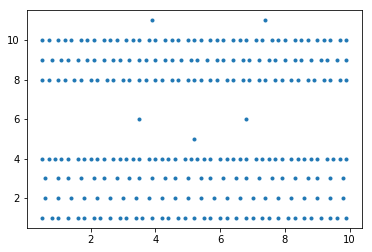

In [496]:
dSD = nest.GetStatus(detector)[0]
events = dSD["events"]["senders"]
ts = dSD["events"]["times"]
#Vm2 = dmm["events"]["V_m"][1::num_class]
#t2 = dmm["events"]["times"][1::num_class]

plt.figure(1)
#pylab.plot(t1, np.cumsum(Vm1))
plt.plot(ts, events, '.')

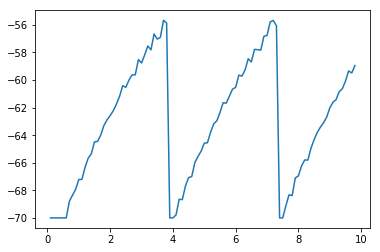

In [497]:
dmm = nest.GetStatus(multi)[0]
events = dmm["events"]["senders"]
Vm = dmm["events"]["V_m"]
tm = dmm["events"]["times"]
#Vm2 = dmm["events"]["V_m"][1::num_class]
#t2 = dmm["events"]["times"][1::num_class]

plt.figure(1)
#pylab.plot(t1, np.cumsum(Vm1))
plt.plot(tm, Vm)

In [488]:
weight

array([[ 0.07087621,  0.31245058,  0.14921033,  0.06516947, -0.11085168,
         0.21183528, -0.0906221 ,  0.56884643,  0.6732289 , -0.16924054]])

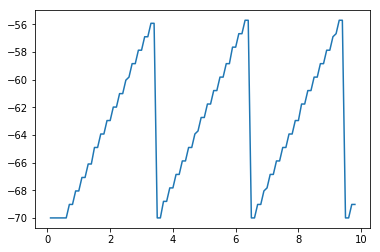

In [467]:
dmm = nest.GetStatus(multi)[0]
events = dmm["events"]["senders"]
Vm = dmm["events"]["V_m"]
tm = dmm["events"]["times"]
#Vm2 = dmm["events"]["V_m"][1::num_class]
#t2 = dmm["events"]["times"][1::num_class]

plt.figure(1)
#pylab.plot(t1, np.cumsum(Vm1))
plt.plot(tm, Vm)